Developing a model to determine anamolies within a dataset 

Step 1: Importing my libraries

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Step 2: Data Collection

I am using the hfs.raw.1.csv file from the game TimeSpy to test my model

In [26]:
df = pd.read_csv('ABN_AlanWake2_2.results.0.dx12-2160p-ultra-NewGameGameplay_._test_wishGranted.csv')
df

,Delta_Time,Time,Running GPU Ticks,GT Effective Freq,GPU_Busy,GTI_Busy,GT Unslice Request Freq,GT Slice Request Freq,GT Slice Freq,GT Unslice Freq,...,PKG Reported Power,PKG Reported Temp,GT Temp,GTI Rd BW,GTI Wr BW,GTI Total BW,Perf Limited,GT RC6,Load Markers,Test Markers
0,0.000000,0.000000,0,0.000000,0.000000,0.00000,6666.8,6666.8,0,0,...,0.000000,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,1,0.000000,0.0,0.0
1,0.108308,0.108308,3567914431,0.000000,9.806062,74284.25552,6666.8,6666.8,0,400,...,59.578423,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.415384,0.0,0.0
2,0.111446,0.219754,3567914431,0.000000,7.073093,-72192.62376,6666.8,6666.8,0,400,...,19.701727,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.602431,0.0,0.0
3,0.109638,0.329392,3567914431,0.000000,7.709417,0.00000,6666.8,6666.8,0,0,...,19.666995,45,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.849983,0.0,0.0
4,0.109810,0.439202,3608273648,367.536809,5.417800,73285.74318,6666.8,6666.8,0,400,...,20.104195,45,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.575027,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,0.108989,913.895839,815034218,0.000000,20.129298,0.00000,6666.8,6666.8,0,0,...,20.648765,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.721676,0.0,0.0
8324,0.109504,914.005343,920022761,958.764456,20.083315,129742.44360,6666.8,6666.8,0,400,...,20.605719,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.726148,0.0,0.0
8325,0.107581,914.112924,920022761,0.000000,15.657901,-132061.57730,6666.8,6666.8,0,0,...,19.612425,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.793038,0.0,0.0
8326,0.109937,914.222861,920022761,0.000000,18.077366,0.00000,6666.8,6666.8,0,0,...,20.258629,46,NO CALC,NO CALC,NO CALC,NO CALCNO CALC,0,0.754038,0.0,0.0


Step 3: Data Cleaning/Preprocessing

feature engineering steps:

1. seeing the column names

2. determing what the unique values are in each column

3. If there are columns with the same value in each row, then dropping those rows because an isolation forest can not pick up on any variance in that regard.

4. looking at some statistical values per column (.describe())

5. make histograms to see where there could be outliers

In [27]:
print(df.columns)

Index(['Delta_Time', 'Time', 'Running GPU Ticks', 'GT Effective Freq',
       'GPU_Busy', 'GTI_Busy', 'GT Unslice Request Freq',
       'GT Slice Request Freq', 'GT Slice Freq', 'GT Unslice Freq',
       'CrystalClock', 'IA Freq', 'Ring Freq', 'SA Freq', 'PKG Reported Power',
       'PKG Reported Temp', 'GT Temp', 'GTI Rd BW', 'GTI Wr BW',
       'GTI Total BW', 'Perf Limited', 'GT RC6', 'Load Markers',
       'Test Markers'],
      dtype='object')


In [28]:
def check_unique_one(data_frame):
    return_column = []
    for column in data_frame.columns:
        unique_values = data_frame[column].unique()
        if len(unique_values) == 1:
            return_column.append(column)
    return return_column
columns_unique = check_unique_one(df)

In [29]:
df_cleaned = df.drop(columns = columns_unique )
df_cleaned

,Delta_Time,Time,Running GPU Ticks,GT Effective Freq,GPU_Busy,GTI_Busy,GT Unslice Request Freq,GT Slice Request Freq,GT Unslice Freq,IA Freq,PKG Reported Power,PKG Reported Temp,Perf Limited,GT RC6,Load Markers,Test Markers
0,0.000000,0.000000,0,0.000000,0.000000,0.00000,6666.8,6666.8,0,4900,0.000000,46,1,0.000000,0.0,0.0
1,0.108308,0.108308,3567914431,0.000000,9.806062,74284.25552,6666.8,6666.8,400,4900,59.578423,46,0,0.415384,0.0,0.0
2,0.111446,0.219754,3567914431,0.000000,7.073093,-72192.62376,6666.8,6666.8,400,4900,19.701727,46,0,0.602431,0.0,0.0
3,0.109638,0.329392,3567914431,0.000000,7.709417,0.00000,6666.8,6666.8,0,4900,19.666995,45,0,0.849983,0.0,0.0
4,0.109810,0.439202,3608273648,367.536809,5.417800,73285.74318,6666.8,6666.8,400,4900,20.104195,45,0,0.575027,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,0.108989,913.895839,815034218,0.000000,20.129298,0.00000,6666.8,6666.8,0,4900,20.648765,46,0,0.721676,0.0,0.0
8324,0.109504,914.005343,920022761,958.764456,20.083315,129742.44360,6666.8,6666.8,400,5000,20.605719,46,0,0.726148,0.0,0.0
8325,0.107581,914.112924,920022761,0.000000,15.657901,-132061.57730,6666.8,6666.8,0,4900,19.612425,46,0,0.793038,0.0,0.0
8326,0.109937,914.222861,920022761,0.000000,18.077366,0.00000,6666.8,6666.8,0,4900,20.258629,46,0,0.754038,0.0,0.0


In [30]:
df_cleaned.describe()

,Delta_Time,Time,Running GPU Ticks,GT Effective Freq,GPU_Busy,GTI_Busy,GT Unslice Request Freq,GT Slice Request Freq,GT Unslice Freq,IA Freq,PKG Reported Power,PKG Reported Temp,Perf Limited,GT RC6,Load Markers,Test Markers
count,8328.000000,8328.000000,8.328000e+03,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000
mean,0.109790,457.410476,2.103378e+09,498.914355,27.580576,-6.018976,15765.623103,15765.623103,513.161143,4721.781940,38.087894,47.602546,0.135567,0.618499,0.068504,0.007325
std,0.003140,264.225323,1.267672e+09,973.202983,29.192559,57494.475909,21749.864787,21749.864787,958.545115,849.564116,39.500236,4.981947,0.342348,0.295124,0.046453,0.026056
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-132999.151900,6666.800000,6666.800000,0.000000,500.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000
25%,0.108620,228.328057,9.161670e+08,0.000000,10.978515,0.000000,6666.800000,6666.800000,0.000000,4900.000000,20.098114,46.000000,0.000000,0.595980,0.000000,0.000000
50%,0.109640,456.955629,2.143292e+09,0.000000,16.834477,0.000000,6666.800000,6666.800000,0.000000,5000.000000,20.936687,46.000000,0.000000,0.718654,0.100000,0.000000
75%,0.110644,686.764137,3.222716e+09,396.066181,25.449785,2.597340,6666.800000,6666.800000,400.000000,5000.000000,22.252948,46.000000,0.000000,0.815501,0.100000,0.000000
max,0.209615,914.330109,4.294248e+09,6103.430520,99.965640,131789.796700,70834.750000,70834.750000,2850.000000,5100.000000,179.273463,64.000000,1.000000,1.345788,0.100000,0.100000


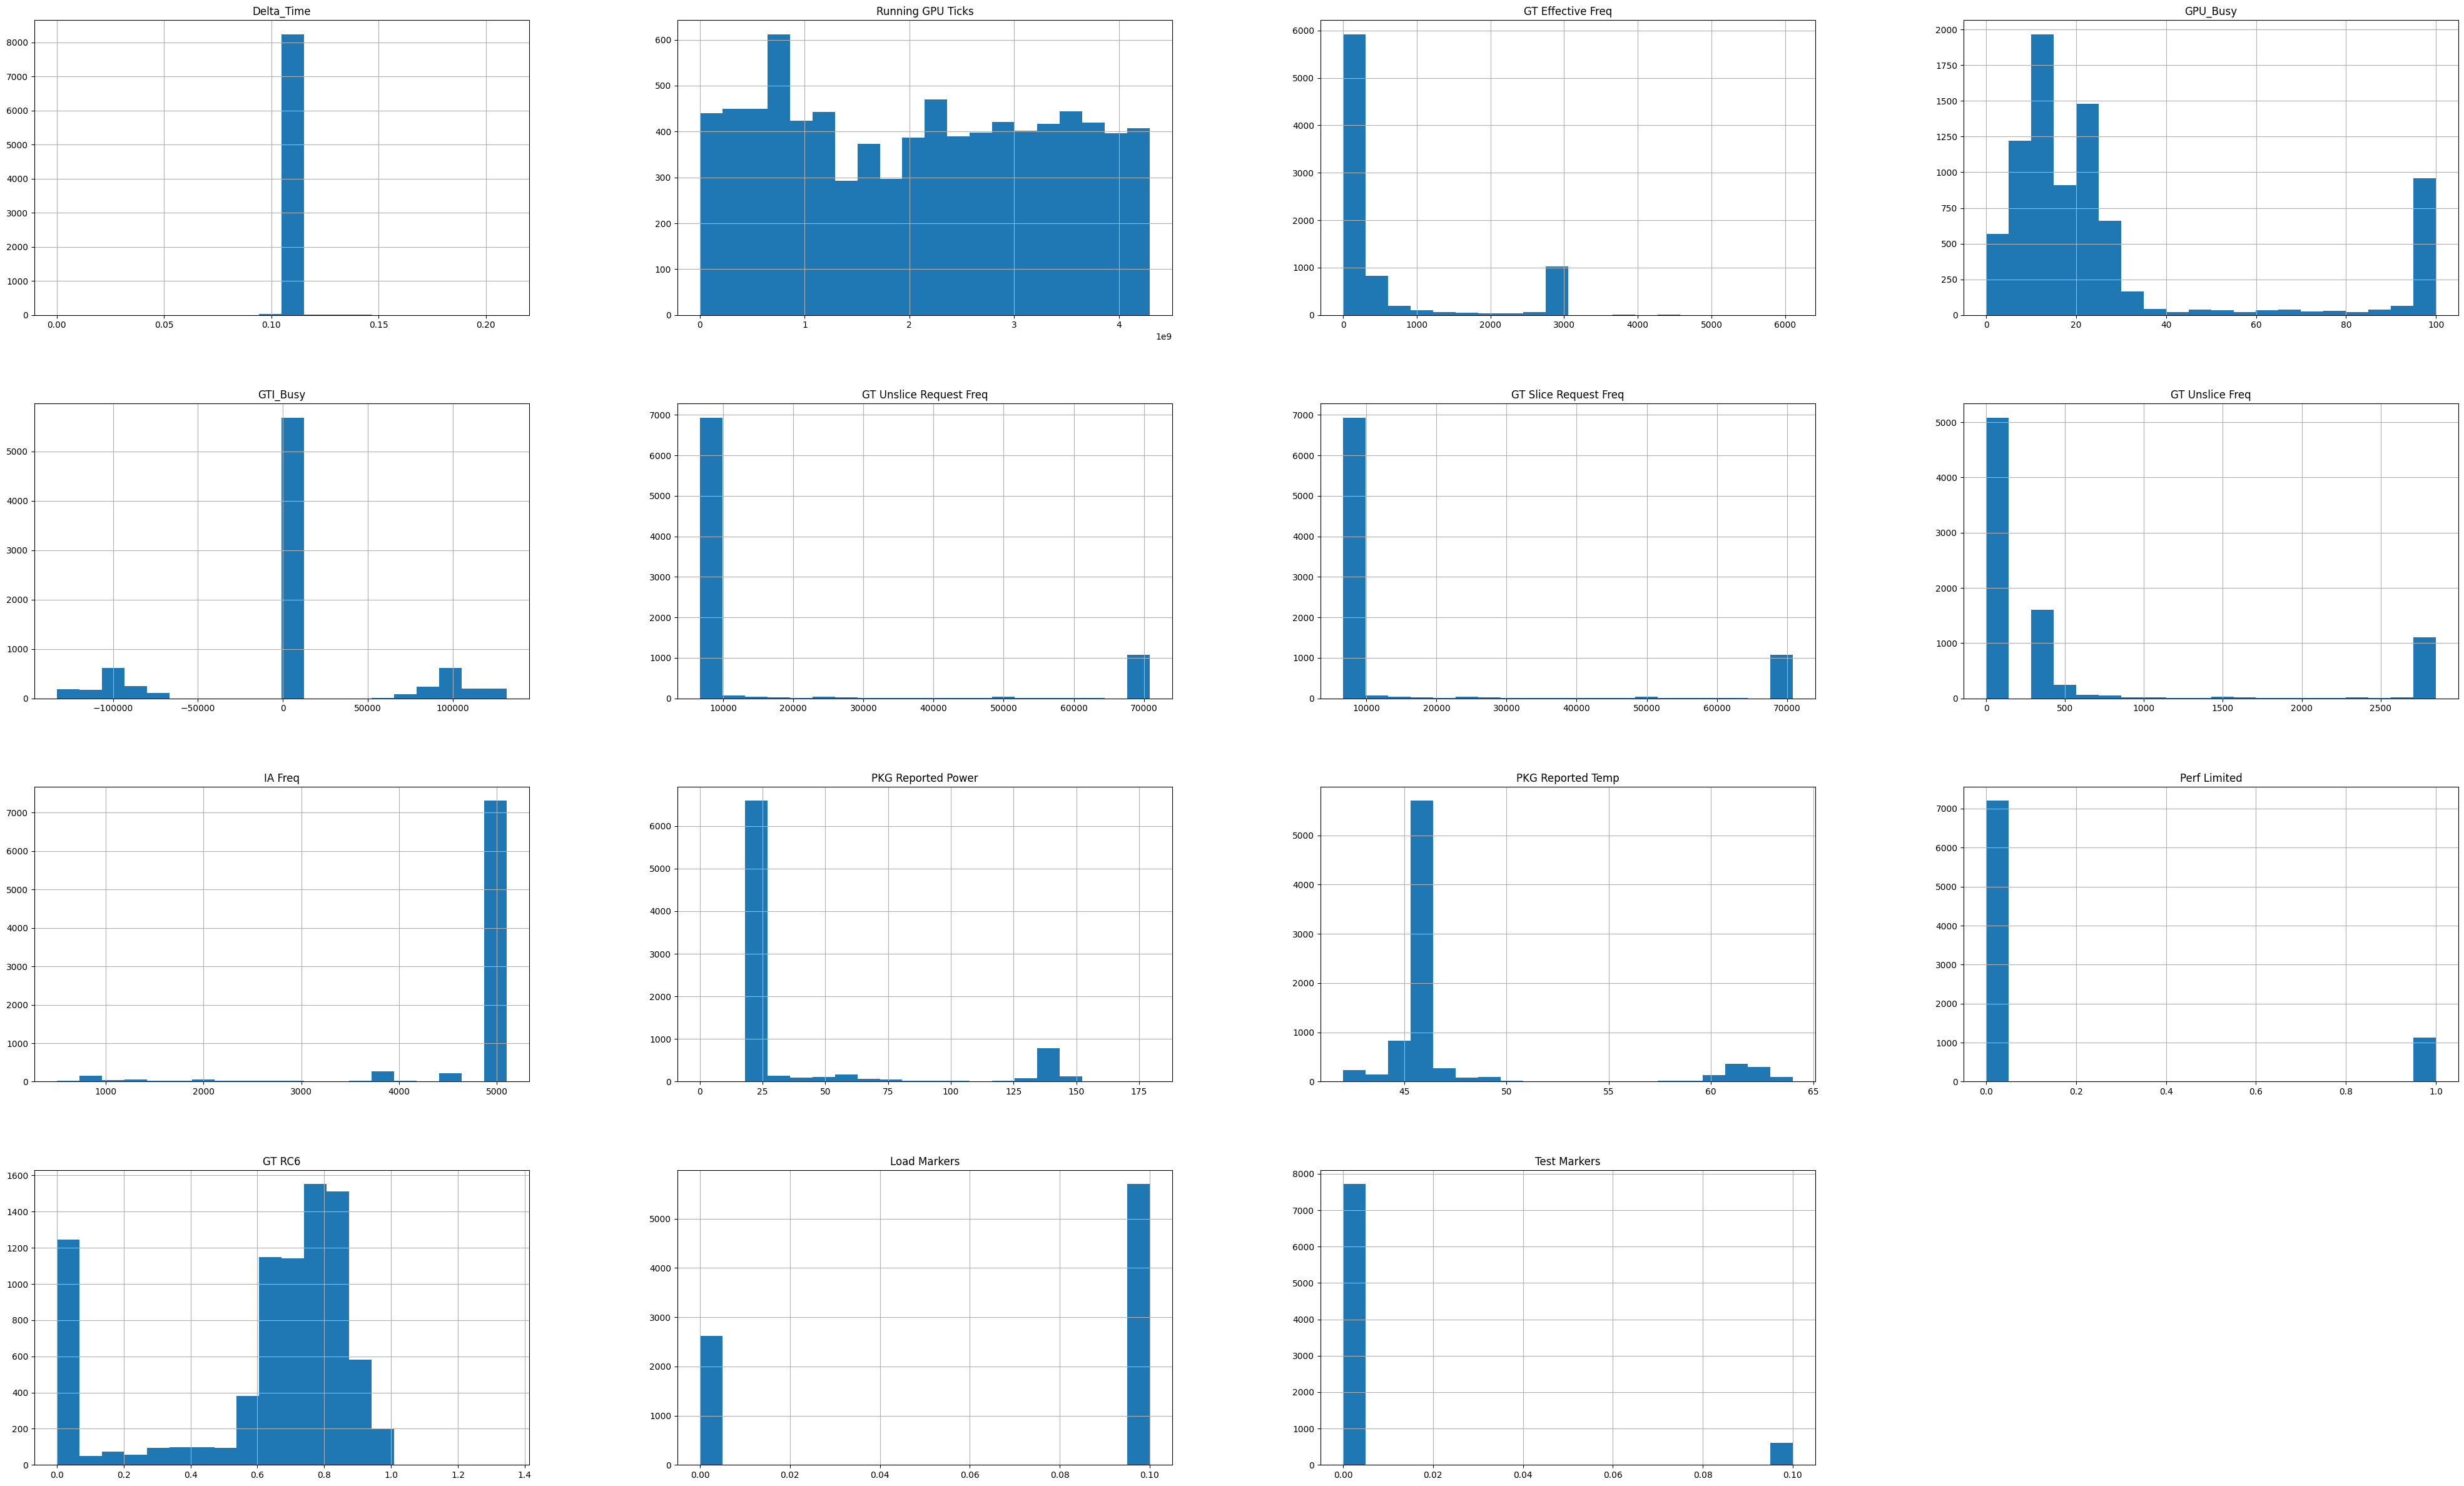

In [31]:
sample_z_score = df_cleaned.drop(columns='Time')
sample_z_score.hist(bins = 20, figsize =(50, 30))
plt.show()

In [32]:
#if they have two unique values, I'll drop because they are basically identifiers
def check_unique_two(df):
    return_column = []
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 2:
            print(f"{column}")
            return_column.append(column)
    return return_column
unique_two_columns = check_unique_two(df)

Perf Limited
Load Markers
Test Markers


Step 4: The Model

In [33]:
#generally getting in the 1500-1700 range for the number of outliers 
sample_isf = df_cleaned.drop(columns='Time')
# Train the model
isf = IsolationForest()
isf.fit(sample_isf)
# Predictions
predictions = isf.predict(sample_isf)
# Extract scores
sample_isf["iso_forest_scores"] = isf.decision_function(sample_isf)
# Extract predictions
sample_isf["iso_forest_outliers"] = predictions
# Replace "-1" with "Yes" and "1" with "No"
sample_isf['iso_forest_outliers'] = sample_isf['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
sample_isf.head()


,Delta_Time,Running GPU Ticks,GT Effective Freq,GPU_Busy,GTI_Busy,GT Unslice Request Freq,GT Slice Request Freq,GT Unslice Freq,IA Freq,PKG Reported Power,PKG Reported Temp,Perf Limited,GT RC6,Load Markers,Test Markers,iso_forest_scores,iso_forest_outliers
0,0.000000,0,0.000000,0.000000,0.00000,6666.8,6666.8,0,4900,0.000000,46,1,0.000000,0.0,0.0,-0.087126,Yes
1,0.108308,3567914431,0.000000,9.806062,74284.25552,6666.8,6666.8,400,4900,59.578423,46,0,0.415384,0.0,0.0,0.006674,No
2,0.111446,3567914431,0.000000,7.073093,-72192.62376,6666.8,6666.8,400,4900,19.701727,46,0,0.602431,0.0,0.0,0.049338,No
3,0.109638,3567914431,0.000000,7.709417,0.00000,6666.8,6666.8,0,4900,19.666995,45,0,0.849983,0.0,0.0,0.109909,No
4,0.109810,3608273648,367.536809,5.417800,73285.74318,6666.8,6666.8,400,4900,20.104195,45,0,0.575027,0.0,0.0,0.029206,No


In [34]:
sample_isf_2 = df_cleaned.drop(columns='Time')
# Standardize features
sample_scaled = StandardScaler().fit_transform(sample_isf_2)
# Define dimensions = 2
pca = PCA(n_components=2)
# Conduct the PCA
principal_comp = pca.fit_transform(sample_scaled)
# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
pca_df.head()
# Train the model
isf_2 = IsolationForest()
isf_2.fit(pca_df)
# Predictions
predictions = isf_2.predict(pca_df)
# Extract scores
pca_df["iso_forest_scores"] = isf_2.decision_function(pca_df)
# Extract predictions
pca_df["iso_forest_outliers"] = predictions
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
pca_df.head()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,-0.615825,-12.061474,-0.190957,Yes
1,-0.332218,-0.852187,0.025228,No
2,-0.921669,-1.237085,0.064974,No
3,-1.366630,-1.289424,0.080711,No
4,-0.813502,-0.702558,0.080488,No


In [35]:
import plotly.express as px

# Function to plot firms on the 2-dimensional space
def plot_firms(dataframe, title, color=None):
    """ Plot firms on the 2-dimensional space """
    
    # Generate a scatter plot with index in hover data
    fig = px.scatter(
        dataframe, 
        x="principal_component_1", 
        y="principal_component_2", 
        title=title, 
        color=color,
        hover_data={'index': dataframe.index}  # Include index in hover data
    )
    
    # Layout
    fig.update_layout(
        font_family='Arial Black',
        title=dict(font=dict(size=20, color='red')),
        yaxis=dict(tickfont=dict(size=13, color='black'),
                   title=dict(font=dict(size=15, color='black'))),
        xaxis=dict(tickfont=dict(size=13, color='black'),
                   title=dict(font=dict(size=15, color='black'))),
        legend=dict(font=dict(size=10, color='black')),
        plot_bgcolor='white'
    )
      
    return fig

# Plot [1] All firms
plot_firms(pca_df, "Figure 1: All Points").show()

In [36]:
# [2] Normal Firms vs. Outlier Firms
plot_firms(dataframe=pca_df, title="Figure 2: Normal Points vs. Outlier Points", color='iso_forest_outliers').show()

Step 5: Fix & Improve

1. Split the data based on different periods in the test and run separate isolation forests based on both.

2. Write the index for each point based on the data [completed]

3. Add frame rate as another metric.

4. Determine what metrics are included in each principal component.

Period 1: Game Menu Start

In [37]:
df_p1 = df_cleaned.iloc[0:5604,:]
df_p1.shape

(5604, 16)

In [38]:
#generally getting in the 1500-1700 range for the number of outliers 
sample_isf_3 = df_p1.drop(columns='Time')
# Train the model
isf_3= IsolationForest()
isf_3.fit(sample_isf_3)
# Predictions
predictions = isf_3.predict(sample_isf_3)
# Extract scores
sample_isf_3["iso_forest_scores"] = isf_3.decision_function(sample_isf_3)
# Extract predictions
sample_isf_3["iso_forest_outliers"] = predictions
# Replace "-1" with "Yes" and "1" with "No"
sample_isf_3['iso_forest_outliers'] = sample_isf_3['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
sample_isf_3.head()

,Delta_Time,Running GPU Ticks,GT Effective Freq,GPU_Busy,GTI_Busy,GT Unslice Request Freq,GT Slice Request Freq,GT Unslice Freq,IA Freq,PKG Reported Power,PKG Reported Temp,Perf Limited,GT RC6,Load Markers,Test Markers,iso_forest_scores,iso_forest_outliers
0,0.000000,0,0.000000,0.000000,0.00000,6666.8,6666.8,0,4900,0.000000,46,1,0.000000,0.0,0.0,-0.110293,Yes
1,0.108308,3567914431,0.000000,9.806062,74284.25552,6666.8,6666.8,400,4900,59.578423,46,0,0.415384,0.0,0.0,-0.059916,Yes
2,0.111446,3567914431,0.000000,7.073093,-72192.62376,6666.8,6666.8,400,4900,19.701727,46,0,0.602431,0.0,0.0,-0.010411,Yes
3,0.109638,3567914431,0.000000,7.709417,0.00000,6666.8,6666.8,0,4900,19.666995,45,0,0.849983,0.0,0.0,0.007354,No
4,0.109810,3608273648,367.536809,5.417800,73285.74318,6666.8,6666.8,400,4900,20.104195,45,0,0.575027,0.0,0.0,-0.030736,Yes


In [39]:
sample_isf_4 = df_cleaned.drop(columns='Time')
# Standardize features
sample_scaled_2 = StandardScaler().fit_transform(sample_isf_4)
# Define dimensions = 2
pca_2 = PCA(n_components=2)
# Conduct the PCA
principal_comp_2 = pca.fit_transform(sample_scaled_2)
# Convert to dataframe
pca_df_2 = pd.DataFrame(data = principal_comp_2, columns = ['principal_component_1', 'principal_component_2'])
pca_df_2.head()
# Train the model
isf_4 = IsolationForest()
isf_4.fit(pca_df)
# Predictions
predictions_2 = isf_4.predict(pca_df_2)
# Extract scores
pca_df_2["iso_forest_scores"] = isf_4.decision_function(pca_df_2)
# Extract predictions
pca_df_2["iso_forest_outliers"] = predictions_2
# Replace "-1" with "Yes" and "1" with "No"
pca_df_2['iso_forest_outliers'] = pca_df_2['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
pca_df_2.head()

ValueError: could not convert string to float: 'Yes'